In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from astropy.constants import c
from scipy.optimize import curve_fit
c = c.value*1e-6 #Speed of light in mm/ns

In [2]:
ydatadir = '../data/15-02 150GHz Ypol/'
yfiles = glob(ydatadir + 'fts_150GHz_20160419_0*.txt') 
xdatadir = '../data/15-02 150GHz Xpol/'
xfiles = glob(xdatadir + 'fts_150GHz_20160419_0*.txt')
files = yfiles + xfiles
myfilter = '15-02'
freq = '150GHz'
L = 1.75*25.4 # thickness of the etalon in mm
# print files

In [3]:
def quadratic(x, A, B, C):
    return A*x**2 + B*x + C

In [4]:
index, time, encoder, signal = np.loadtxt(files[0], comments='#', skiprows=17, unpack=True)
index2, time2, encoder2, signal2 = np.loadtxt(files[1], comments='#', skiprows=17, unpack=True)
# encoder /= c/2
# encoder2 /= c/2

# Find the right position of the origin of the interferogram
peak = np.where(signal == max(signal))[0][0]
y = signal[peak-1: peak+2]
x = encoder[peak-1:peak+2]
X = np.vstack([x**2, x, np.ones_like(x)]).T
A = np.linalg.solve(X, y)
actual_peak = -A[1]/(2*A[0])
sig_peak = quadratic(actual_peak, *list(A))
#Let's try out I(z) - I(0)/2
signal -= sig_peak/2
print encoder[peak]
encoder -= actual_peak
encoder *=2 # Encoder now represents the path length difference

peak2 = np.where(signal2 == max(signal2))[0][0]
y = signal2[peak2-1: peak2+2]
x = encoder2[peak2-1:peak2+2]
X = np.vstack([x**2, x, np.ones_like(x)]).T
A2 = np.linalg.solve(X, y)
actual_peak2 = -A[1]/(2*A[0])
sig_peak2 = quadratic(actual_peak2, *list(A2))
#Let's try out I(z) - I(0)/2
signal2 -= sig_peak2/2
print encoder2[peak2]
encoder2 -= actual_peak2
encoder2 *=2 # Encoder now represents the path length difference

# peak = encoder[np.where(signal == max(signal))[0]][0]
# thresh = np.logical_and(encoder > (peak - 1.0), encoder < (peak + 1.0))
# thresh2 = np.logical_and(encoder2 > (peak - 1.0), encoder2 < (peak + 1.0))
# encoder = encoder[thresh]
# signal = signal[thresh]
# encoder2 = encoder2[thresh2]
# signal2 = signal2[thresh2]

# # Remove the dc component as much as we can
# mean = np.average(signal)
# signal -= mean

# mean2 = np.average(signal2)
# signal2 -= mean2



388.1025
388.12


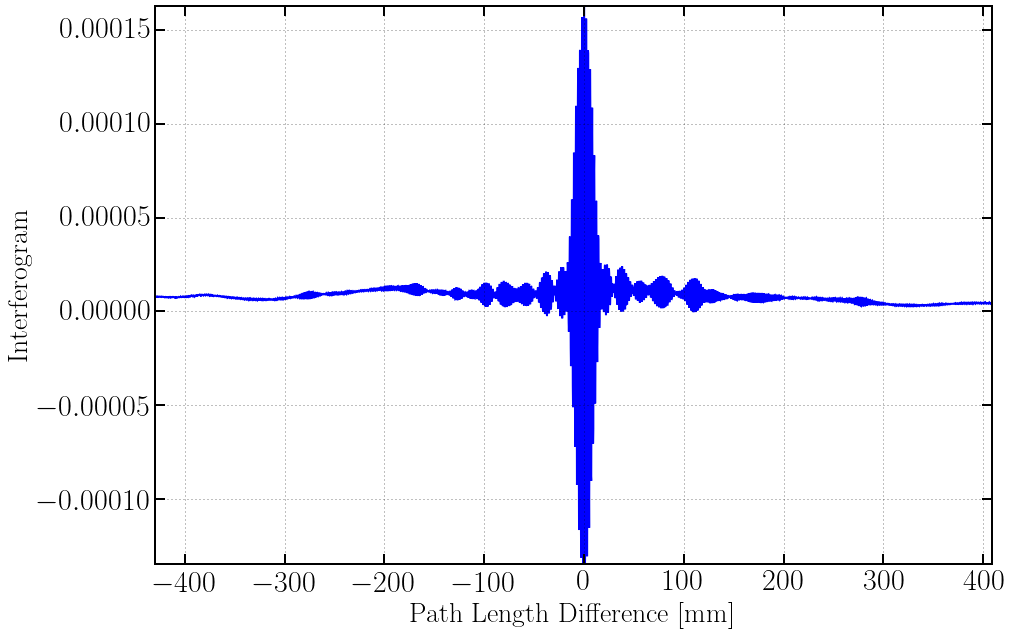

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(encoder2, signal2)
ax.set_xlabel('Path Length Difference [mm]')
ax.set_ylabel('Interferogram')
ax.axis('tight')
ax.grid();
plt.savefig('assymetricinterferogram.png')

In [6]:
#Find the point of max signal in the interferogram. That is the point of zero path length difference
peak = np.where(signal == max(signal))[0][0]
y = signal[peak-1: peak+2]
x = encoder[peak-1:peak+2]
X = np.vstack([x**2, x, np.ones_like(x)]).T
A = np.linalg.solve(X, y)
print A
actual_peak = -A[1]/(2*A[0])
print actual_peak
print encoder[peak]
dpeak = actual_peak - encoder[peak]
encoder += dpeak
print encoder[peak]

[ -7.31349101e-04  -1.97981697e-13   1.68235801e-04]
-1.35353756942e-10
-0.00147971124363
-1.35353756849e-10


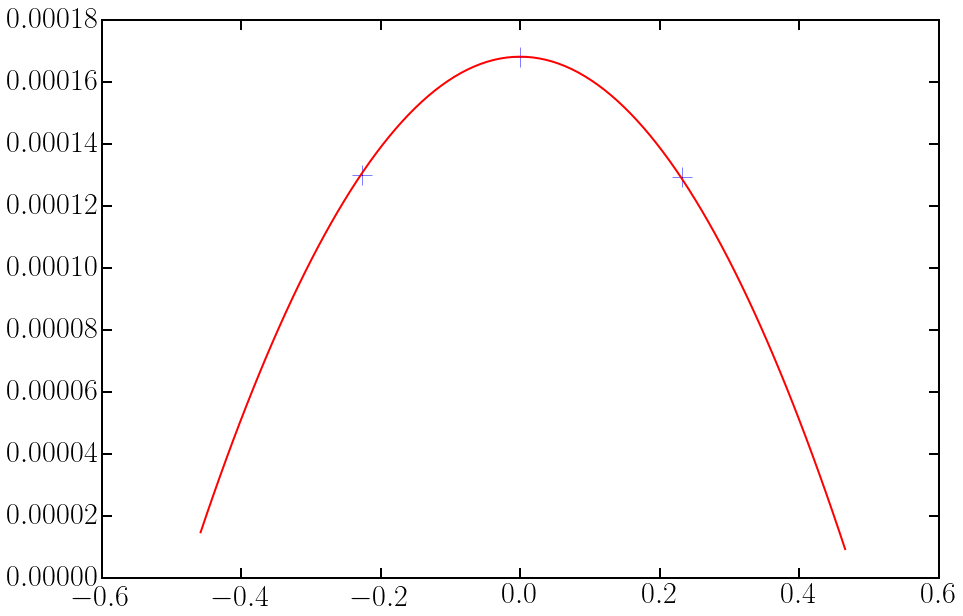

In [7]:
fig, ax =plt.subplots(figsize=(15,10))
ax.plot(encoder[peak-1: peak+2], signal[peak-1: peak+2], 'b+', markersize=20)
# ax.axis('tight');
xs = np.r_[encoder[peak-2]:encoder[peak+2]:100j]
ax.plot(xs, quadratic(xs, *list(A)), 'r-')
# fig, ax =plt.subplots(figsize=(15,10))
# ax.plot(encoder2, signal2, 'b-x')
# ax.axis('tight');

In [8]:
from scipy.fftpack import fft, fftfreq, ifft
y1 = fft(signal)
d1 = np.mean(np.diff(encoder))
n1 = len(encoder)
k1 = fftfreq(n1,d1)

#### Second sample
# signal2 *= np.cos(-encoder2*a)
y2 = fft(signal2)
d2 = np.mean(np.diff(encoder2))
n2 = len(encoder2)
k2 =fftfreq(n2,d2)

peak2 =  np.where(y2 == max(y2))[0]
peak1 = np.where(y1 == max(y1))[0]
a = k1[peak1] - k2[peak2]

In [9]:
# fig, ax =plt.subplots(figsize=(15,10))
# ax.plot(signal, signal2, 'r.')
# ax.grid(which='major');

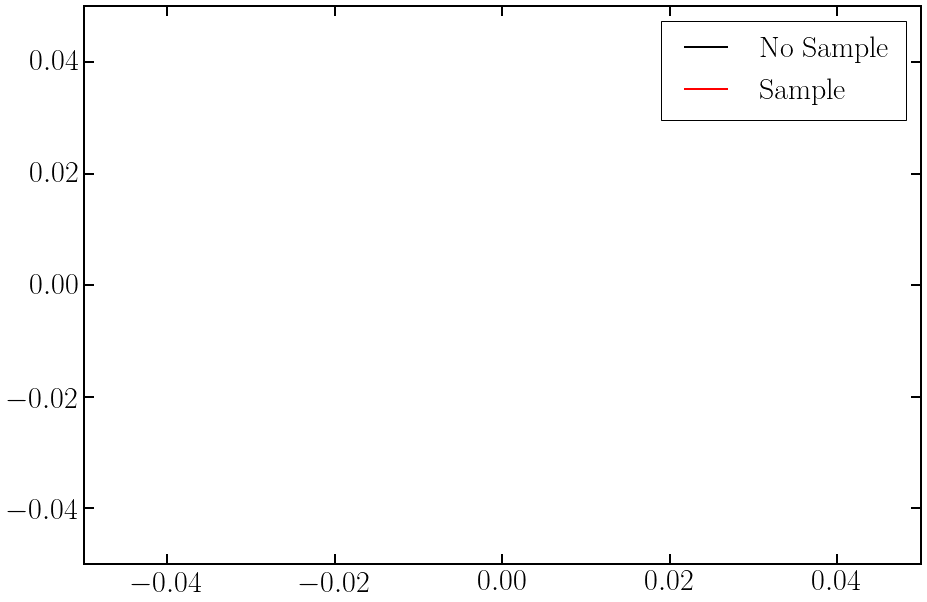

In [10]:
fig, ax =plt.subplots(figsize=(15,10))
thresh = np.logical_and(k1 > 140, k1 < 160)
thresh2 = np.logical_and(k2 > 140, k2 < 160)
ax.plot(k1[thresh], np.abs(y1)[thresh],'k', label='No Sample');
ax.plot(k2[thresh2], np.abs(y2)[thresh2],'r', label='Sample')
# ax.plot(np.abs(y1)[thresh],'k', label='No Sample');
# ax.plot(np.abs(y2)[thresh2],'r', label='Sample')
ax.legend()
ax.axis('tight');

In [ ]:
absorption = np.abs(y2[thresh2])/np.abs(y1[thresh])

fig, ax =plt.subplots(figsize=(15,10))
ax.plot(k1[thresh], absorption)
ax.grid(which='major')
ax.set_xlabel('Frequency, GHz');
ax.set_ylabel('Transmission')
ax.axis('tight');

In [ ]:
# L = 2.25*25.4 # thickness of the etalon in mm
# from scipy.optimize import curve_fit

# def transmission(nu, T, A, F, theta, dr):
#     lamb = c/nu
#     delta = (4*np.pi*np.cos(theta)*L/lamb) + dr
#     return (T/(A+T))**2*(1 - F * (1 - np.cos(delta))/2)

# # guesses = [0.01, np.pi/2]
# popt, pcov = curve_fit(transmission, k1[thresh], absorption)
# print popt

In [ ]:
# fig, ax =plt.subplots(figsize=(15,10))
# ax.plot(k1[thresh], absorption, 'r.-')
# ax.plot(k1[thresh], transmission(k1[thresh], *popt), 'b')
# ax.grid(which='major')
# ax.set_xlabel('Frequency, GHz');
# ax.set_ylabel('Transmission')
# ax.axis('tight');

In [ ]:
index, time, encoder, signal = np.loadtxt(files[2], comments='#', skiprows=17, unpack=True)
mean = np.average(signal)
signal -= mean
encoder /= c/2
index2, time2, encoder2, signal2 = np.loadtxt(files[3], comments='#', skiprows=17, unpack=True)
mean2 = np.average(signal2)
signal2 -= mean2
encoder2 /= c/2
peak = encoder[np.where(signal == max(signal))[0]][0]
thresh = np.logical_and(encoder > (peak - 1.0), encoder < (peak + 1.0))
thresh2 = np.logical_and(encoder2 > (peak - 1.0), encoder2 < (peak + 1.0))
encoder = encoder[thresh]
signal = signal[thresh]
encoder2 = encoder2[thresh2]
signal2 = signal2[thresh2]
# fig, ax =plt.subplots(figsize=(15,10))
# ax.plot(encoder, signal, 'b')
# ax.axis('tight');
y1 = fft(signal)
d1 = np.mean(np.diff(encoder))
n1 = len(encoder)
k1 = fftfreq(n1,d1)
#### Second sample
y2 = fft(signal2)
d2 = np.mean(np.diff(encoder2))
n2 = len(encoder2)
k2 =fftfreq(n2,d2)
# peak2 =  np.where(y2 == max(y2))[0]
# peak1 = np.where(y1 == max(y1))[0]
# a = k1[peak1] - k2[peak2]
# print a
# k2 += a
fig, ax =plt.subplots(figsize=(15,10))
thresh = np.logical_and(k1 > 120, k1 < 180)
thresh2 = np.logical_and(k2 > 120, k2 < 180)
ax.plot(k1[thresh], np.abs(y1)[thresh],'k', label='No Sample');
ax.plot(k2[thresh2], np.abs(y2)[thresh2],'r', label='Sample');
ax.legend();

In [ ]:
index, time, encoder, signal = np.loadtxt(datadir + 'fts_150GHz_20160404_002.txt', comments='#', skiprows=17, unpack=True)
mean = np.average(signal)
signal -= mean
encoder /= c/2
index2, time2, encoder2, signal2 = np.loadtxt(datadir + 'fts_150GHz_20160404_003.txt', comments='#', skiprows=17, unpack=True)
mean2 = np.average(signal2)
signal2 -= mean2
encoder2 /= c/2
peak = encoder[np.where(signal == max(signal))[0]][0]
thresh = np.logical_and(encoder > (peak - 1.0), encoder < (peak + 1.0))
thresh2 = np.logical_and(encoder2 > (peak - 1.0), encoder2 < (peak + 1.0))
encoder = encoder[thresh]
signal = signal[thresh]
encoder2 = encoder2[thresh2]
signal2 = signal2[thresh2]
y1 = fft(signal)
d1 = (encoder[1]-encoder[0])
n1 = len(encoder)
k1 =fftfreq(n1,d1)
#### Second sample
y2 = fft(signal2)
d2 = (encoder2[1]-encoder2[0])
n2 = len(encoder2)
k2 =fftfreq(n2,d2)
# peak2 =  np.where(y2 == max(y2))[0]
# peak1 = np.where(y1 == max(y1))[0]
# a = k1[peak1] - k2[peak2]
# print a
# k2 += a
fig, ax =plt.subplots(figsize=(15,10))
thresh = np.logical_and(k1 > 120, k1 < 180)
thresh2 = np.logical_and(k2 > 120, k2 < 180)
ax.plot(k1[thresh], np.abs(y1)[thresh],'k', label='No Sample');
ax.plot(k2[thresh2], np.abs(y2)[thresh2],'r', label='Sample');
# ax.plot(k1, np.abs(y1),'k', label='No Sample');
# ax.plot(k2, np.abs(y2),'r', label='Sample');
ax.legend();

In [ ]:
dx = np.mean(np.diff(encoder))
dx2 = np.mean(np.diff(encoder2))

print dx, dx2

# fig, ax = plt.subplots(figsize=(15,10))
# ax.plot(encoder[1:], dx, 'r.')
# # ax.plot(dx2, 'b.');

In [ ]:
(popt[0]/(popt[0] + popt[1]))**2

In [ ]:
c/(25.4*2.25)

In [ ]:
c

In [ ]:
0.197/0.5

In [ ]:
from astropy.constants import h,c,G,m_n
hbar = h/(2*np.pi)
R = (9*np.pi/4)**(2./3)*hbar**2/(G*m_n**3*(1.2e57)**(1./3))
R.to('km')

In [ ]:
E_f = hbar**2/(2*m_n*R**2)*(9*np.pi/4*1.2e57)**(2./3)
E_f.to('GeV')

In [ ]:
(9*np.pi/4*1.2e57)**(2./3)

In [ ]:
0.057/0.94

In [ ]:
peak